In [ ]:
# Import library yang diperlukan
import numpy as np
from shutil import copy2
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import tensorflow_hub as hub
import pickle
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Mount ke drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set datadir tempat data train berada dan variabel
DATADIR = '/content/drive/MyDrive/Colab Notebooks/trainingSample/'
IMAGE_SHAPE = (224, 224)

In [ ]:
# Rescale image dan split menjadi data train dan validation
datagen_kwargs = dict(rescale=1./255, validation_split=.20)

# Buat train_generator dan valid_generator
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    DATADIR, 
    subset="validation", 
    shuffle=True,
   target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    DATADIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE
    )

Found 120 images belonging to 10 classes.
Found 480 images belonging to 10 classes.


In [ ]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 10))

In [ ]:
# Tampilkan train_generator 
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}


In [ ]:
# Buat model klasifikasi
# Disini menggunakan TensorFlow hub untuk me-load pre-trained model
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
# Compile model
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(
  optimizer=optimizer,
  loss='categorical_crossentropy',
  metrics=['acc'])

In [ ]:
# Train model
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(
    train_generator, 
    epochs=100,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch).history

Epoch 1/100
15/15 [==============================] - 24s 1s/step - loss: 2.4431 - acc: 0.1542 - val_loss: 2.0608 - val_acc: 0.3333
Epoch 2/100
15/15 [==============================] - 17s 1s/step - loss: 2.0287 - acc: 0.2500 - val_loss: 1.7759 - val_acc: 0.4667
Epoch 3/100
15/15 [==============================] - 18s 1s/step - loss: 1.7330 - acc: 0.3958 - val_loss: 1.5870 - val_acc: 0.6083
Epoch 4/100
15/15 [==============================] - 19s 1s/step - loss: 1.5506 - acc: 0.4854 - val_loss: 1.4559 - val_acc: 0.6750
Epoch 5/100
15/15 [==============================] - 18s 1s/step - loss: 1.4242 - acc: 0.5437 - val_loss: 1.3520 - val_acc: 0.6667
Epoch 6/100
15/15 [==============================] - 16s 1s/step - loss: 1.3204 - acc: 0.5875 - val_loss: 1.2720 - val_acc: 0.6667
Epoch 7/100
15/15 [==============================] - 17s 1s/step - loss: 1.2094 - acc: 0.6354 - val_loss: 1.1930 - val_acc: 0.6917
Epoch 8/100
15/15 [==============================] - 16s 1s/step - loss: 1.1272 - a

In [ ]:
# Cek akurasi model
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final akurasi: {:.2f}%".format(final_accuracy * 100))

4/4 [==============================] - 3s 763ms/step - loss: 0.4942 - acc: 0.8583
Final loss: 0.49
Final akurasi: 85.83%


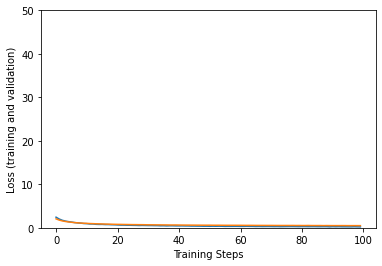

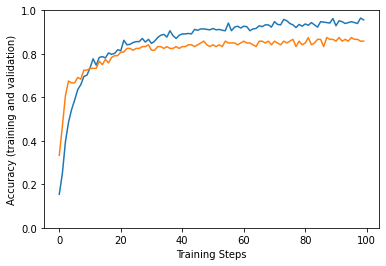

In [ ]:
# Plotting grafik untuk mengetahui seberapa bagus training dan validasi
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,50])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

In [ ]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [ ]:
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [ ]:
tf_model_predictions = model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (32, 10)


In [ ]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
print(predicted_labels)

['3' '4' '3' '0' '5' '3' '4' '6' '9' '2' '6' '5' '7' '9' '0' '8' '3' '8'
 '3' '7' '4' '3' '3' '0' '8' '2' '5' '6' '2' '9' '3' '1']


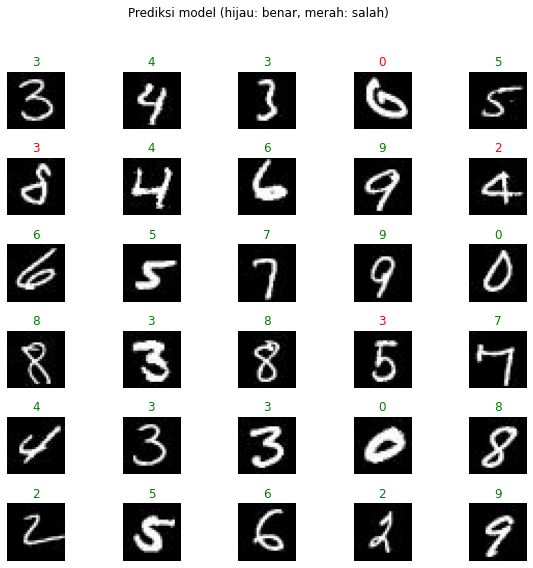

In [ ]:
# Cek performa model
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range((len(predicted_labels)-2)):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Prediksi model (hijau: benar, merah: salah)")

In [ ]:
# Simpan model ke dalam file pickle
pickle.dump(tf_model_predictions, open(DATADIR+"/model.pkl", "wb"))